# Results
This notebook compares the loss logs from the GNCA (Tensorflow) and the Pytorch version.

In [23]:
import os

PT_DIR = "../reproduction/pytorch"
TF_DIR = "../reproduction/gnca"

# in the TF_DIR, there are subdirs for each model, load the final_loss_log.json into a DF
import pandas as pd
import json
from pathlib import Path

def load_loss_log(model_dir):
    with open(Path(model_dir) / "final_loss_log.json", "r") as f:
        loss_log = json.load(f)
    df = pd.DataFrame(loss_log)
    return df

# in the PT_DIR, there are subdirs for each model, load the metrics.jsonl into a DF
# {"ts": "2025-08-27T01:13:58.695128+00:00", "run_id": "results/2025-08-27/111355_replicate-fish-regen-40x40", "phase": "train", "ca_step": 73, "step": 0, "loss": 0.07898864895105362, "mse": 0.07898864895105362, "grad_norm": 0.9999994039535522}
def load_metrics_log(model_dir):
    records = []
    with open(Path(model_dir) / "metrics.jsonl", "r") as f:
        for line in f:
            record = json.loads(line)
            records.append(record)
    df = pd.DataFrame(records)
    return df

# load all models in TF_DIR
tf_models = [d for d in os.listdir(TF_DIR) if os.path.isdir(os.path.join(TF_DIR, d))]
tf_dfs = {}
for model in tf_models:
    tf_dfs[model] = load_loss_log(os.path.join(TF_DIR, model))

# load all models in PT_DIR
pt_models = [d for d in os.listdir(PT_DIR) if os.path.isdir(os.path.join(PT_DIR, d))]
pt_dfs = {}
for model in pt_models:
    pt_dfs[model] = load_metrics_log(os.path.join(PT_DIR, model))

# print keys and counts
print("TF models:", len(tf_dfs.keys()), ":", tf_dfs.keys())
print("PT models:", len(pt_dfs.keys()), ":", pt_dfs.keys())
shared_keys = set(tf_dfs.keys()) & set(pt_dfs.keys())
print("Common models:", len(shared_keys), ":", shared_keys)
# missing models
print("Missing in TF:", set(pt_dfs.keys()) - set(tf_dfs.keys()))
print("Missing in PT:", set(tf_dfs.keys()) - set(pt_dfs.keys()))

TF models: 16 : dict_keys(['smiley_persistent', 'ladybug_persistent', 'fish_regenerating', 'fish_persistent', 'smiley_growing2', 'web_persistent', 'lizard_growing', 'lizard_persistent', 'smiley_growing', 'fish_growing', 'web_growing', 'smiley_regenerating', 'lizard_regenerating', 'ladybug_growing', 'ladybug_regenerating', 'web_regenerating'])
PT models: 15 : dict_keys(['smiley_persistent', 'ladybug_persistent', 'fish_regenerating', 'fish_persistent', 'web_persistent', 'lizard_growing', 'lizard_persistent', 'smiley_growing', 'fish_growing', 'web_growing', 'smiley_regenerating', 'lizard_regenerating', 'ladybug_growing', 'ladybug_regenerating', 'web_regenerating'])
Common models: 15 : {'lizard_growing', 'smiley_regenerating', 'fish_growing', 'lizard_persistent', 'ladybug_regenerating', 'ladybug_growing', 'web_regenerating', 'web_persistent', 'web_growing', 'fish_regenerating', 'ladybug_persistent', 'lizard_regenerating', 'smiley_growing', 'smiley_persistent', 'fish_persistent'}
Missing in

In [24]:
# rename the column in tf_dfs to loss (the column doesn't have a name, it's just Index([0]))
for key in tf_dfs.keys():
    tf_dfs[key] = tf_dfs[key].rename(columns={tf_dfs[key].columns[0]: "loss"})

In [27]:
def resample_to_common_grid(x1, y1, x2, y2, n=2000):
    xmin, xmax = max(x1.min(), x2.min()), min(x1.max(), x2.max())
    grid = np.linspace(xmin, xmax, n)
    y1g = np.interp(grid, x1, y1)
    y2g = np.interp(grid, x2, y2)
    return grid, y1g, y2g

def iqr_overlap_fraction(x, lo1, hi1, lo2, hi2, n=2000):
    g, lo1g, hi1g = resample_to_common_grid(x, lo1, x, hi1, n)  # same x for both arrays
    _, lo2g, hi2g = resample_to_common_grid(x, lo2, x, hi2, n)
    # overlap length at each grid point (0 if disjoint)
    overlap = np.maximum(0.0, np.minimum(hi1g, hi2g) - np.maximum(lo1g, lo2g))
    is_overlap = overlap > 0
    return is_overlap.mean(), g, overlap  # fraction of grid with overlap

def time_to_threshold(x, y, thresh):
    """First step where y <= thresh; returns np.nan if never crosses."""
    if (y <= thresh).any():
        idx = np.argmax(y <= thresh)
        return x[idx]
    return np.nan

def closeness_metrics(pt_steps, m_pt, tf_steps, m_tf,
                      lo_pt=None, hi_pt=None, lo_tf=None, hi_tf=None,
                      thresh=1e-3, n_grid=2000):
    # 1) common grid (handles different step arrays)
    g, m_pt_g, m_tf_g = resample_to_common_grid(pt_steps, m_pt, tf_steps, m_tf, n=n_grid)
    diff = m_pt_g - m_tf_g
    adiff = np.abs(diff)

    # 2) aggregate gaps (trapezoidal average)
    aag = np.trapz(adiff, g) / (g[-1] - g[0])                  # Average Absolute Gap
    rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))      # RMSE of gap
    maxgap = adiff.max(); step_at_max = g[adiff.argmax()]
    rel_gap_pct = (adiff / (0.5 * (np.abs(m_pt_g) + np.abs(m_tf_g)))).mean() * 100

    # 3) late-phase gap (last 10%)
    cut = int(0.9 * len(g))
    aag_tail = adiff[cut:].mean()

    # 4) IQR overlap (optional)
    overlap_frac = np.nan
    if lo_pt is not None and hi_pt is not None and lo_tf is not None and hi_tf is not None:
        overlap_frac, _, _ = iqr_overlap_fraction(pt_steps, lo_pt, hi_pt, lo_tf, hi_tf, n=n_grid)

    # 5) time-to-threshold (using original step domains)
    t_pt = time_to_threshold(pt_steps, m_pt, np.log10(thresh) if False else thresh)
    t_tf = time_to_threshold(tf_steps, m_tf, np.log10(thresh) if False else thresh)
    # NOTE: if your curves are already log10(loss), pass thresh on that scale, e.g. thresh= -3.0

    return {
        "avg_abs_gap": aag,
        "rmse_gap": rmse,
        "max_gap": maxgap,
        "step_at_max_gap": step_at_max,
        "relative_gap_pct": rel_gap_pct,
        "avg_abs_gap_tail": aag_tail,
        "iqr_overlap_fraction": overlap_frac,  # 0..1
        "t_to_thresh_pt": t_pt,
        "t_to_thresh_tf": t_tf,
        "delta_t_to_thresh": (t_pt - t_tf) if np.isfinite(t_pt) and np.isfinite(t_tf) else np.nan,
    }

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_7765/1196040785.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(min(lo_pt.min(), lo_tf.min()) - 0.1,
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_7765/3280144677.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])                  # Average Absolute Gap
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_7765/3280144677.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))      # RMSE of gap


Metrics for model 'lizard_growing':
           avg_abs_gap: 0.00013321102314351355
              rmse_gap: 0.0002880681878199522
               max_gap: 0.0014656997700895052
       step_at_max_gap: 408.20410205102553
      relative_gap_pct: 14.80544283274628
      avg_abs_gap_tail: 2.5129319702578467e-05
  iqr_overlap_fraction: 1.0
        t_to_thresh_pt: 541
        t_to_thresh_tf: 449
     delta_t_to_thresh: 92
Metrics for model 'smiley_regenerating':
           avg_abs_gap: 0.0012462208311175645
              rmse_gap: 0.0018036692196884611
               max_gap: 0.0076079334674208285
       step_at_max_gap: 204.10205102551276
      relative_gap_pct: 23.934171443445827
      avg_abs_gap_tail: 0.0006322547125330977
  iqr_overlap_fraction: 0.5615
        t_to_thresh_pt: 2512
        t_to_thresh_tf: 2675
     delta_t_to_thresh: -163
Metrics for model 'fish_growing':
           avg_abs_gap: 0.00022255269673388128
              rmse_gap: 0.0004515072244556139
               max_gap: 0.

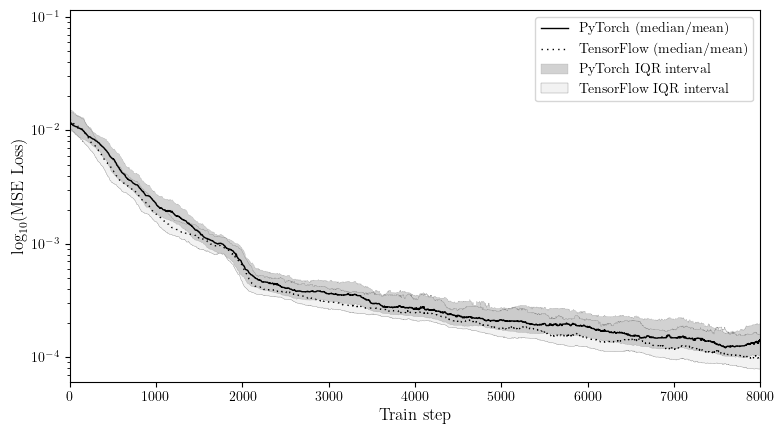

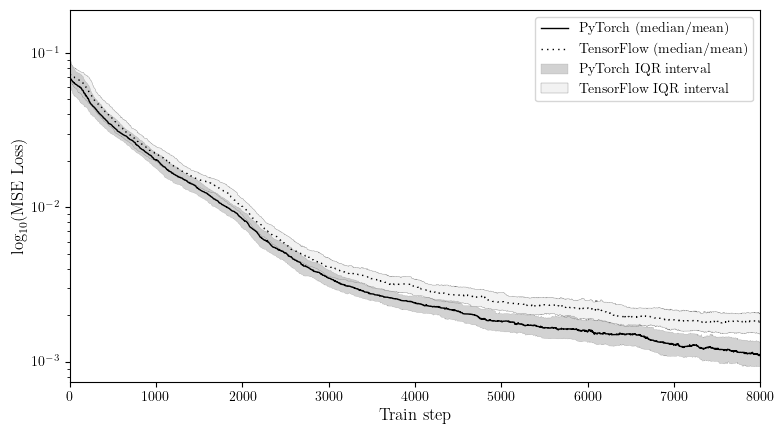

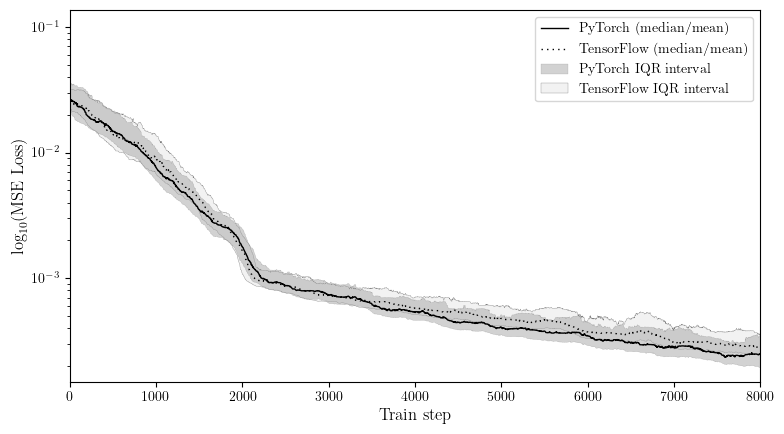

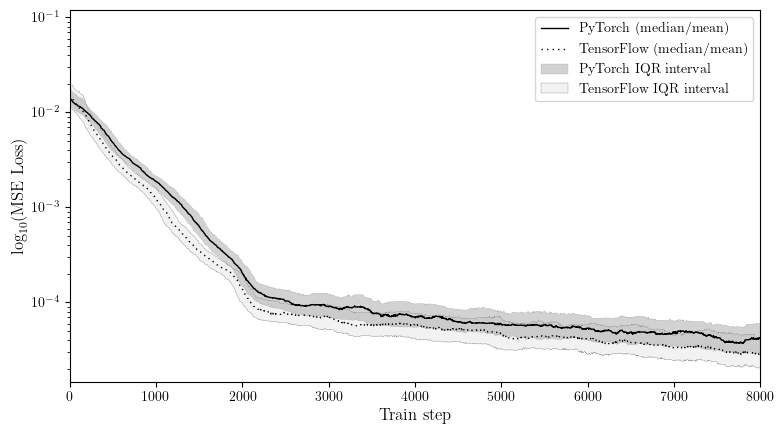

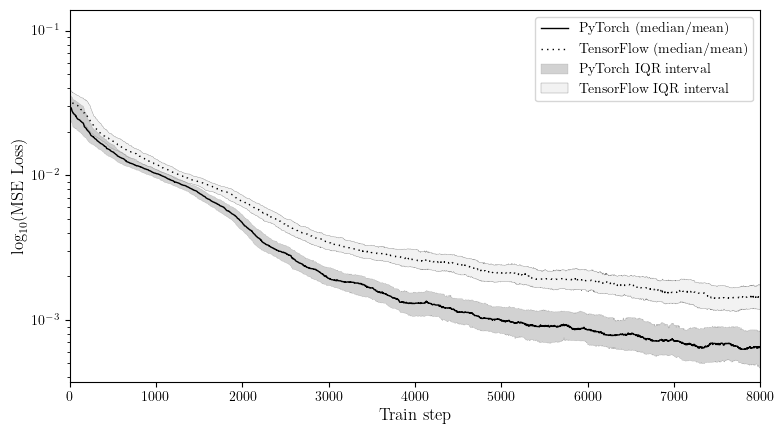

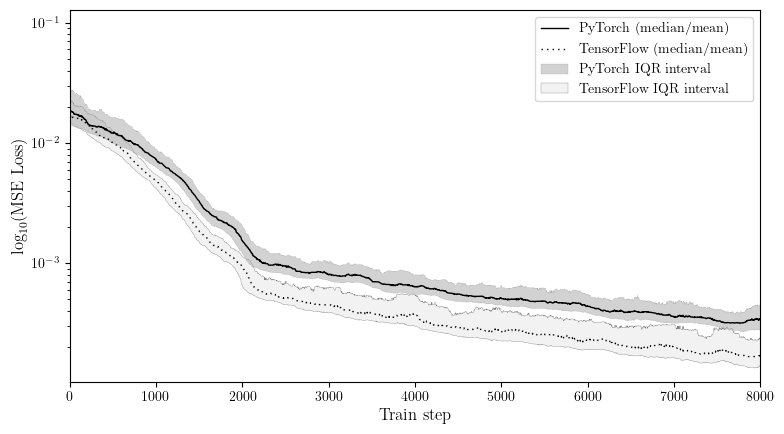

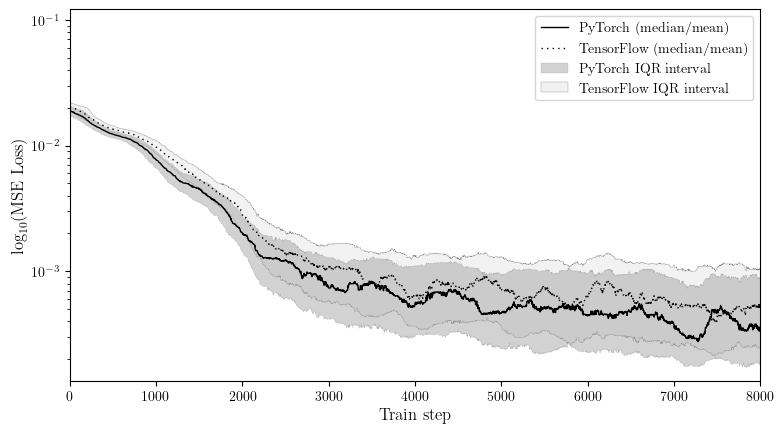

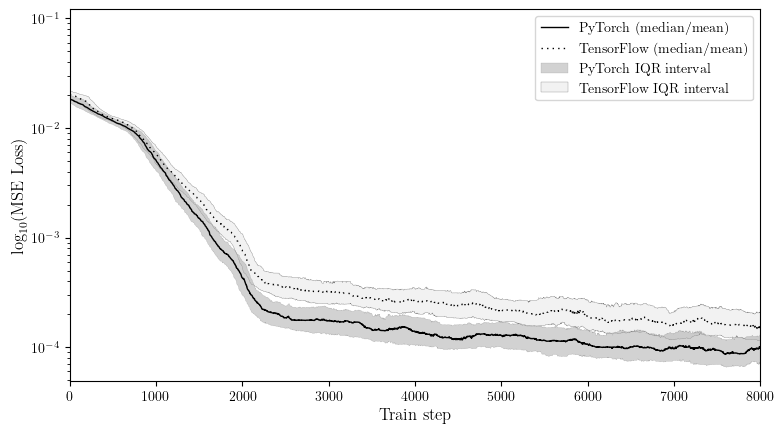

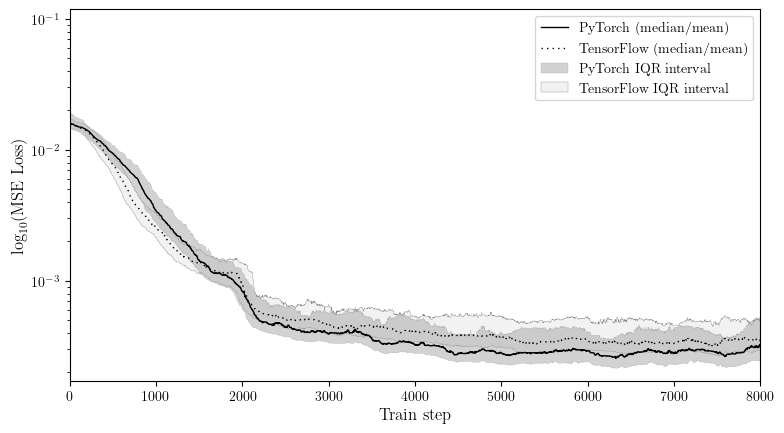

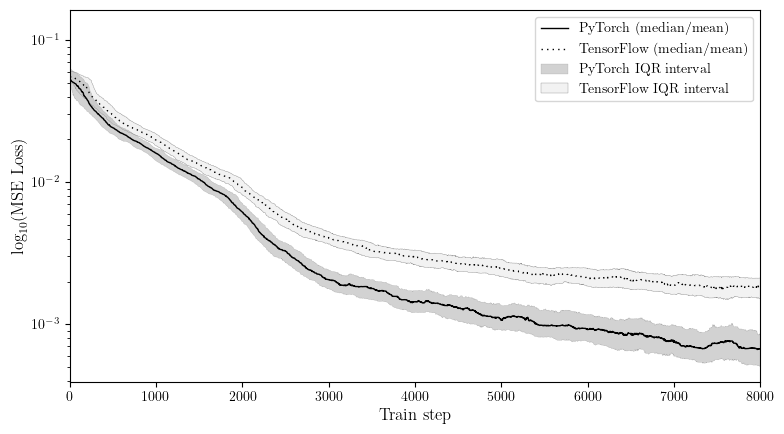

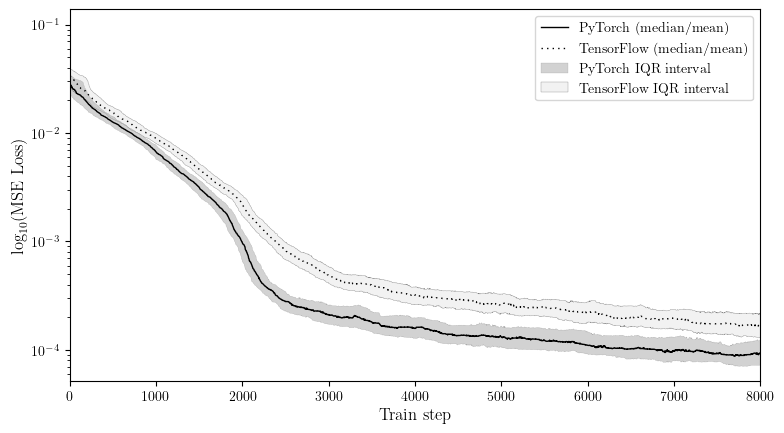

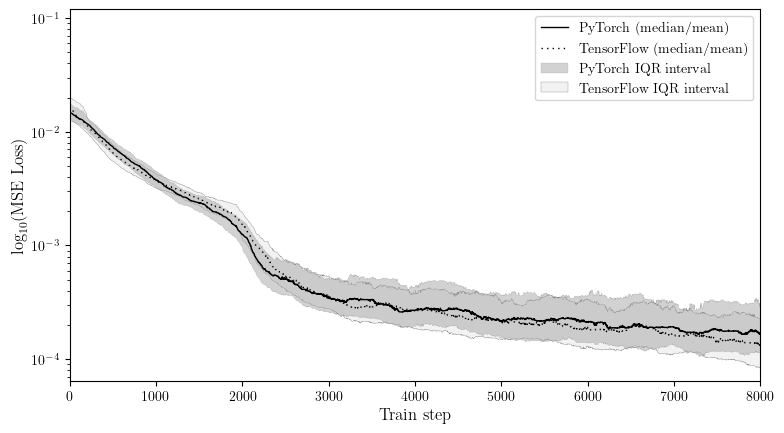

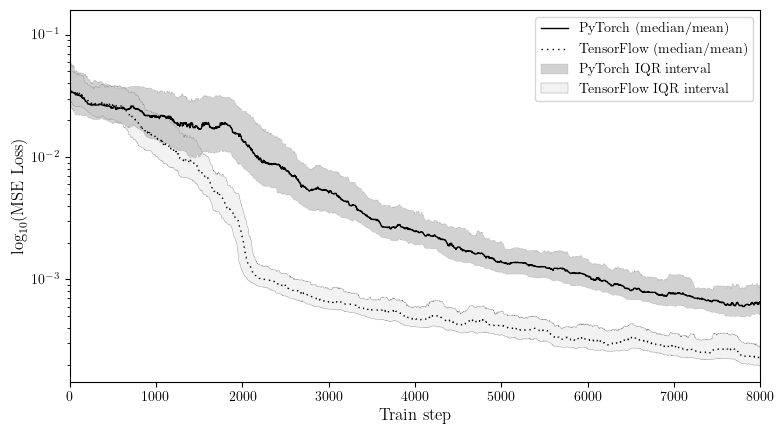

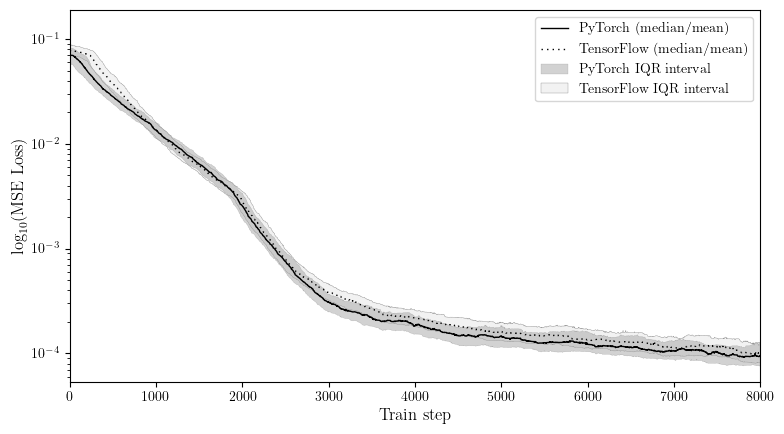

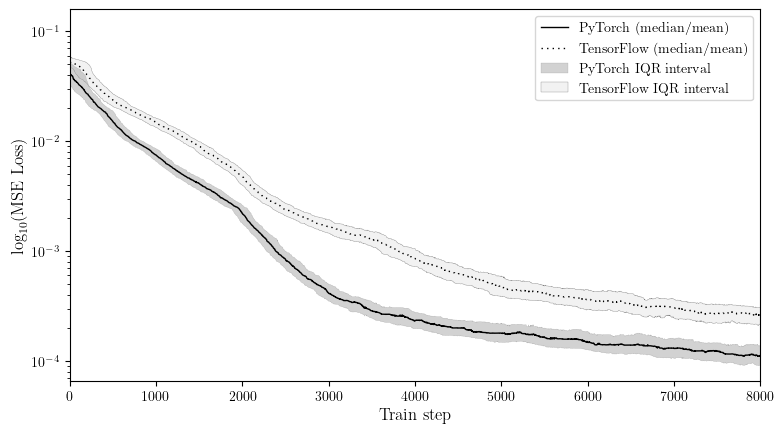

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Patch

def hatched_band(ax, x, ylo, yhi, *, label=None,
                 facecolor='0.92', edgecolor='0.5', hatch=None,
                 linewidth=0.4, zorder=0, alpha=1.0):
    # underlay
    fb = ax.fill_between(x, ylo, yhi, facecolor=facecolor, edgecolor=edgecolor,
                         linewidth=linewidth, alpha=alpha, zorder=zorder, label=None)

    # optiona lhatching
    if hatch:
        xs = np.concatenate([x, x[::-1]])
        ys = np.concatenate([yhi, ylo[::-1]])
        poly = Polygon(np.c_[xs, ys], closed=True, facecolor='none', edgecolor=edgecolor,
                       hatch=hatch, linewidth=linewidth, zorder=zorder + 0.1)
        ax.add_patch(poly)
        # proxy for legend
        proxy = Patch(facecolor=facecolor, edgecolor=edgecolor, hatch=hatch, label=label)
        return proxy  # put this in the legend
    else:
        fb.set_label(label)
        return fb

def make_plot(ypt, ytf, key):
        pt_steps = np.arange(len(y_pt))
        tf_steps = np.arange(len(y_tf))

        win = 301 # smoothing window
        m_pt = pd.Series(y_pt).rolling(win, center=True, min_periods=1).median().to_numpy()
        m_tf = pd.Series(y_tf).rolling(win, center=True, min_periods=1).median().to_numpy()
        lo_pt = pd.Series(y_pt).rolling(win, center=True, min_periods=1).quantile(0.25).to_numpy()
        hi_pt = pd.Series(y_pt).rolling(win, center=True, min_periods=1).quantile(0.75).to_numpy()
        lo_tf = pd.Series(y_tf).rolling(win, center=True, min_periods=1).quantile(0.25).to_numpy()
        hi_tf = pd.Series(y_tf).rolling(win, center=True, min_periods=1).quantile(0.75).to_numpy()

        fig, ax = plt.subplots(figsize=(8, 4.5))

        # bands
        pt_hb = hatched_band(ax, pt_steps, lo_pt, hi_pt, hatch=None, facecolor='0.65', edgecolor='0.5', linewidth=0.25, zorder=0, label='PyTorch IQR interval', alpha=0.5)
        tf_hb = hatched_band(ax, tf_steps, lo_tf, hi_tf, hatch=None, facecolor='0.95', edgecolor='0.5', linewidth=0.25, zorder=-1, label='TensorFlow IQR interval')

        # mean lines
        pt_line, = ax.plot(pt_steps, m_pt, color='black', linewidth=1, linestyle='-',
                label='PyTorch (median/mean)')
        tf_line, = ax.plot(tf_steps, m_tf, color='black', linewidth=1, linestyle=(0, (1, 3)),
                label='TensorFlow (median/mean)')


        plt.yscale("log")

        ax.set_xlabel('Train step')
        ax.set_ylabel("$\log_{10}$(MSE Loss)")
        ax.legend(handles=[pt_line, tf_line, pt_hb, tf_hb], frameon=True)
        ax.set_ylim(min(lo_pt.min(), lo_tf.min()) - 0.1,
                max(hi_pt.max(), hi_tf.max()) + 0.1)
        ax.margins(x=0)
        plt.tight_layout()
        plt.savefig(f'figures/reproduction_loss_{key}.pdf')


        # also print some metrics
        # If your y-values are log10(loss), choose a threshold on the **same scale**, e.g. thresh=-3.0
        metrics = closeness_metrics(
                pt_steps, m_pt, tf_steps, m_tf,
                lo_pt=lo_pt, hi_pt=hi_pt, lo_tf=lo_tf, hi_tf=hi_tf,
                thresh=0.005, #-3.0,  # log10(1e-3)
                n_grid=2000
                )
        
        print(f"Metrics for model '{key}':")
        for k, v in metrics.items():
                print(f"{k:>22s}: {v}")

for key in shared_keys:
    y_pt = pt_dfs[key]['loss']
    y_tf = tf_dfs[key]['loss']
    make_plot(y_pt, y_tf, key)
